In [1]:
import numpy as np
from RK_bin import *
import matplotlib.pyplot as plt
import matplotlib as mpl

from IPython.display import clear_output
%load_ext autoreload
%autoreload 2

In [2]:
#mpl.use("pgf")

mpl.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'font.size' : 8,
    'text.usetex': True,
    'pgf.rcfonts': False,
})

In [3]:
d = 100
n = 1000000

In [4]:
out = np.zeros(30)
for j in range(30):

    D = (np.random.rand(n)>.9)*9+1.
    A = D[:,None]*(np.random.rand(n,d)>.9)

    rn  = np.linalg.norm(A,axis=1)
    out[j] = np.max(rn)**2/np.sum(rn**2)*n

In [5]:
np.mean(out)

22.96121873226316

In [4]:
np.random.seed(0)
D = (np.random.rand(n)>.9)*9+1.
A = D[:,None]*(np.random.rand(n,d)>.9)
np.random.seed(0)

κ = 20

x_opt = np.random.randn(d)
b = A@x_opt

λ,ℓ,L,κ,κ_,α,β,η,κC = get_params(A,c=1e3)

In [5]:
η,κ,κ_

(22.94172382773045, 12.811800449884142, 1.1758722704241282)

In [6]:
k_max = 70

B = getB(0,α,β,λ,κC,mode='approx')

n_trials = 100

B_scales = [1e0,1e-1,1e-2,1e-3]


In [10]:
err_HBM = []
x_HBM = HBM(A,b,k_max,α,β)
err_HBM.append(np.linalg.norm(x_HBM - x_opt[None,:],axis=1))

In [9]:
err_HBM_mb = []
err_HBM_mb_unif = []
params = []

for scale in B_scales:
    
    err_HBM_mb_expr = np.zeros((n_trials,k_max))
    err_HBM_mb_unif_expr = np.zeros((n_trials,k_max))
    
    np.random.seed(0)
    for j in range(n_trials):
        
        print(f'{scale}, {int(B*scale)}, trial {j}/{n_trials}')
        clear_output(wait=True)
    
        x_HBM_mb = minibatch_HBM(A,b,k_max,α,β,int(B*scale),sampling='row_norm')
        err_HBM_mb_expr[j] = np.linalg.norm(x_HBM_mb - x_opt[None,:],axis=1)

        x_HBM_mb_unif = minibatch_HBM(A,b,k_max,α,β,int(B*scale),sampling='uniform')
        err_HBM_mb_unif_expr[j] = np.linalg.norm(x_HBM_mb_unif - x_opt[None,:],axis=1)

    err_HBM_mb.append(err_HBM_mb_expr)
    err_HBM_mb_unif.append(err_HBM_mb_unif_expr)

0.001, 34, trial 99/100


In [7]:
#np.save('data/sampling_probs.npy',[err_HBM_mb,err_HBM_mb_unif],allow_pickle=True)
[err_HBM_mb,err_HBM_mb_unif] = np.load('data/sampling_probs.npy',allow_pickle=True)

In [8]:
colors = ['#1f4c84','#800000','#976100','#007f00']
line_styles = ['--','-.',(0, (4, 2, 1, 1, 1, 2)),':']

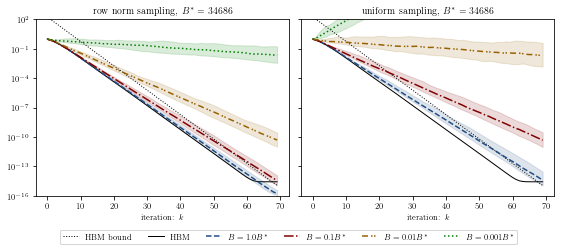

In [12]:
fig,axs = plt.subplots(1,2,figsize=(8,3.5),sharex='col',sharey=True)

plt.subplots_adjust(wspace=.05)
plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=.2)

rate = np.sqrt(2)*κC*np.sqrt(β)**np.arange(k_max)
for j in range(2):
    axs[j].plot(np.arange(k_max),rate,\
                color='k',ls=':',lw=1,label='HBM bound')
    axs[j].plot(np.arange(k_max),err_HBM[0]/err_HBM[0][0],\
                color='k',ls='-',lw=1,label='HBM')

for j,scale in enumerate(B_scales):

    σ = 0.05

    median = np.quantile(err_HBM_mb[j]/err_HBM_mb[j][0,0],.5,axis=0)
    upper = np.quantile(err_HBM_mb[j]/err_HBM_mb[j][0,0],1-σ,axis=0)
    lower = np.quantile(err_HBM_mb[j]/err_HBM_mb[j][0,0],σ,axis=0)
    
    axs[0].plot(np.arange(k_max),median,label=f'$B={scale}B^*$',\
                color=colors[j],ls=line_styles[j])
    axs[0].fill_between(np.arange(k_max),lower,upper,alpha=.15,\
                color=colors[j])

    median = np.quantile(err_HBM_mb_unif[j]/err_HBM_mb_unif[j][0,0],.5,axis=0)
    upper = np.quantile(err_HBM_mb_unif[j]/err_HBM_mb_unif[j][0,0],1.-σ,axis=0)
    lower = np.quantile(err_HBM_mb_unif[j]/err_HBM_mb_unif[j][0,0],σ,axis=0)
    
    axs[1].plot(np.arange(k_max),median,label=f'$B={scale}B^*$',\
                color=colors[j],ls=line_styles[j])
    axs[1].fill_between(np.arange(k_max),lower,upper,alpha=.15,\
                color=colors[j])

axs[0].set_title(f'row norm sampling, $B^*={B}$')
axs[1].set_title(f'uniform sampling, $B^*={B}$')

axs[0].set_yscale('log')
axs[0].set_ylim(1e-16,1e2)

axs[0].set_xlabel('iteration: $k$')
axs[1].set_xlabel('iteration: $k$')

axs[0].legend(loc='upper center', bbox_to_anchor=(1,-.17), ncol=7)

plt.savefig('imgs/sampling_probs.pdf')